In [1]:
import os
import sys
import PIL
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import glob
import csv
import pickle
# Display plots inside the notebook:
%matplotlib inline 

In [2]:
### Helper functions 

# Plot one (m,n,3) image:
def plot_single_image(image, image_title='', figure_size=(10,5)):
    plt.figure(figsize=figure_size)
    plt.title(image_title, fontsize=30)
    plt.imshow(image)
    
# Plot one (m,n,1) image:
def plot_single_image_gray(image, image_title='', figure_size=(10,5)):
    plt.figure(figsize=figure_size)
    plt.title(image_title, fontsize=30)
    plt.imshow(image, cmap='gray')
    
# Plot two (m,n,3) images side by side:
def plot_side_by_side(left_image, right_image, left_title='', right_title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    ax1.set_title(left_title, fontsize=30)
    ax1.imshow(left_image)    
    ax2.set_title(right_title, fontsize=30)
    ax2.imshow(right_image)

# Plot two (m,n,1) images side by side:
def plot_side_by_side_gray(left_image, right_image, left_title='', right_title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))    
    ax1.set_title(left_title, fontsize=30)
    ax1.imshow(left_image, cmap='gray')    
    ax2.set_title(right_title, fontsize=30)
    ax2.imshow(right_image, cmap='gray')        
    
# Plot a histogram: 
def plot_histogram(histogram, histogram_title='', figure_size=(10,5)):
    plt.figure(figsize=figure_size)
    plt.title(histogram_title, fontsize=30)
    plt.plot(histogram)
    
# Read in images from folder:
def get_images_from_folder(folder_name='camera_cal'):
    cwd = os.getcwd()
    path = '{}/{}/{}'.format(cwd, folder_name, 'calibration*.jpg')
    image_paths = glob.glob(path)
    images = []
    for image_path in image_paths:
        image = mpimg.imread(image_path)
        images.append(image)
    return images    

In [3]:
### Camera calibration functions
def calibrate_camera(folder_in='camera_calibration_images', folder_out='camera_calibration_images_output', board_size=(5,9)):
    print('Calibrating', end='')
    nx = board_size[1]
    ny = board_size[0]
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('{}/calibration*.jpg'.format(folder_in))

    # Count the number of images for which corners were found
    num_found = 0
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        print('.', end='')
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            num_found += 1
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            # Save images with found corners to file
            write_name = 'camera_calibration_images_output/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            #plt.imshow(img)
        
            
            
    # Get image size
    # img = cv2.imread(images[0])
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    calibration_data = {}
    calibration_data["mtx"] = mtx
    calibration_data["dist"] = dist
    calibration_data["board_size"] = board_size
    pickle.dump(calibration_data, open("calibration_data.p", "wb" ) )
    #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    if num_found >= 1:
        print('\nCalibration successful')
        print('\nChessboard corners were found on {} of {} images.\n'.format(num_found,len(images)))        
    else:
        print('\nCalibration failed.  Pease try again using different images.') 
    return mtx, dist

In [4]:
### Functions used in image pipeline: original_image --> final_image

def read_in_image(path_in, display_results=False):    
    original_image = cv2.imread(path_in)    
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    if display_results==True:
        plot_single_image(original_image, 'Original Image')
    return original_image
    
    
# Undistort image:
def undistort(original_image, mtx, dist, display_results=False):
    undistorted_image = cv2.undistort(original_image, mtx, dist, None, mtx)
    if display_results==True:
        plot_side_by_side(original_image, undistorted_image, 'Original', 'Undistorted')
    return undistorted_image

def trapezoid(undistorted_image, src, display_results=False):
    img = np.copy(undistorted_image)
    trapezoid_image = cv2.polylines(img, [src], True, (50,205,50), thickness=2)
    if display_results==True:
        plot_single_image(trapezoid_image, 'Trapezoid Image')
    return trapezoid_image

def color_and_gradient_mask(undistorted_image, display_results=False):
    # img = cv2.imread('test_images/straight_lines1.jpg')
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(img.shape)
    # plt.imshow(img)

    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # # NOTE: No noticeable improvement using hsv instead of hls.
    # hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # h2_channel = hls[:,:,0]
    # s2_channel = hls[:,:,1]
    # v2_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    gray = np.copy(s_channel)
    #plt.figure(figsize=(20, 10))
    #plt.imshow(gray, cmap='gray')

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # Green = gradient threshold component
    # Blue  = color threshold component
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

#     # Plotting thresholded images
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#     ax1.set_title('Stacked thresholds')
#     ax1.imshow(color_binary)

#     ax2.set_title('Combined S channel and gradient thresholds')
#     ax2.imshow(combined_binary, cmap='gray')

    if display_results==True:
        plot_side_by_side_gray(color_binary, combined_binary, 'Color and Gradient Mask', 'Combined Binary')
    
    return combined_binary, hls, s_channel, color_binary

def warp_image(combined_binary, src, display_results=False):
    
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100
    # Grab the image shape (width (pos-right), height (pos-down))
    img_size = (combined_binary.shape[1], combined_binary.shape[0])

    # For source points I'm grabbing the outer four detected corners
    # Order: top-left, top-right, bottom-right, bottom-left
    # src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    src = src.astype('float32')
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)   
    
    # Warp the image using OpenCV warpPerspective()
    warped_binary = cv2.warpPerspective(combined_binary, M, img_size)   
    
#     # Unwarp the warped image using OpenCV warpPerspective()
#     unwarped = cv2.warpPerspective(warped, Minv, img_size) 

    if display_results==True:
        plot_side_by_side_gray(combined_binary, warped_binary ,'Combined Binary' , 'Perspective Transform')
    
    return warped_binary, M, Minv

def make_histogram(warped_binary, padding=100, display_results=False):
     # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    # Chop off any histogram values near the edge of the image 
    histogram[:padding] = 0 
    histogram[:len(histogram)-padding-1:-1] = 0   
    
    if display_results==True:
        plot_histogram(histogram, 'Histogram')
    
    return histogram
    
def window_search(warped_binary, histogram, display_results=False):
    # Assuming you have created a warped binary image called "warped_binary"
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Get radius of curvature (average of left and right lines) [meters]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = (left_curverad + right_curverad)/2
    
    
    # Get offset (distance from center of vehicle to center of lane) [meters]
    # negative offset: left-of-center
    # positive offset: right-of-center
    left_line_pos = left_fitx[-1]
    right_line_pos = right_fitx[-1]
    lane_center_pos = ((right_line_pos - left_line_pos)/2) + left_line_pos
    vehicle_center_pos = warped_binary.shape[1]/2
    distance_from_center = (vehicle_center_pos - lane_center_pos)*xm_per_pix
    
    # Create black image with only lines on it
    line_fits_binary = np.zeros((warped_binary.shape[0], warped_binary.shape[1]), dtype='uint8')
    for i in range(len(ploty)):
        try:
            index = (int(ploty[i]), int(left_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
            index = (int(ploty[i]), int(right_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
        except:
            pass

    if display_results==True:
        # ONLY FOR WRITEUP VISUALIZATION
        #Visualization
        #At this point, you're done! But here is how you can visualize the result as well:
        # Generate x and y values for plotting
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure(figsize=(10,5))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.title('Window Search', fontsize=30)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    return line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, out_img

def proximity_search(warped_binary, left_fit, right_fit, display_results=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "warped_binary")
    # It's now much easier to find line pixels!
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

                     
    # Get radius of curvature (average of left and right lines)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_curverad = (left_curverad + right_curverad)/2

    # Get offset (distance from center of vehicle to center of lane) [meters]
    # negative offset: left-of-center
    # positive offset: right-of-center
    left_line_pos = left_fitx[-1]
    right_line_pos = right_fitx[-1]
    lane_center_pos = ((right_line_pos - left_line_pos)/2) + left_line_pos
    vehicle_center_pos = warped_binary.shape[1]/2
    distance_from_center = (vehicle_center_pos - lane_center_pos)*xm_per_pix
    

    # Create black image with only lines on it
    line_fits_binary = np.zeros((warped_binary.shape[0], warped_binary.shape[1]), dtype='uint8')
    for i in range(len(ploty)):
        try:
            index = (int(ploty[i]), int(left_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
            index = (int(ploty[i]), int(right_fitx[i]))
            line_fits_binary[index[0], index[1]] = 255
        except:
            pass   
        
    if display_results==True:
        # ONLY FOR WRITEUP VISUALIZATION
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure(figsize=(10,5))
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.title('Proximity Search', fontsize=30)
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
                     
    return line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, out_img

def fill_image(line_fits_binary, display_results=False):    
    filled_image = np.copy(line_fits_binary)    
    midpoint = filled_image.shape[1]//2
    for i, row in enumerate(filled_image):
        start_point = np.argmax(row[:midpoint])
        end_point = np.argmax(row[midpoint:]) + midpoint

        filled_image[i, start_point:end_point] = 255

    if display_results==True:
        plot_single_image_gray(filled_image, 'Filled Image')
    
    return filled_image

def unwarp_image(filled_image, Minv, cutoff_height=450, display_results=False):
    # Grab the image shape (width (pos-right), height (pos-down))
    img_size = (filled_image.shape[1], filled_image.shape[0])
    # Unwarp the warped image using OpenCV warpPerspective()
    unwarped_image = cv2.warpPerspective(filled_image, Minv, img_size) 
    # Cutoff everything above cutoff_height
    unwarped_image[0:cutoff_height, :] = 0
    
    if display_results==True:
        plot_single_image_gray(unwarped_image, 'Unwarped Image')
    
    return unwarped_image

def reshape_unwarped(unwarped_image, display_results=False):
    reshaped_unwarped_image = np.zeros((unwarped_image.shape[0], unwarped_image.shape[1], 3), dtype='uint8')    
    # Fill shape using the green color channel
    #reshaped_unwarped[:,:,0] = unwarped[:,:]
    reshaped_unwarped_image[:,:,1] = unwarped_image[:,:]
    #reshaped_unwarped[:,:,2] = unwarped[:plt.imshow(reshaped_unwarped)   
    
    if display_results==True:
        plot_single_image(reshaped_unwarped_image, 'Reshaped Unwarped Image')
    
    return reshaped_unwarped_image
    
def weigh_image(reshaped_unwarped_image, original_image, α=0.8, β=1., λ=0., display_results=False):    
    weighted_image = cv2.addWeighted(original_image, α, reshaped_unwarped_image, β, λ)
    
    if display_results==True:
        plot_single_image(weighted_image, 'Weighted Image')
    
    return weighted_image

# Add text overlay to weighted image
# https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html?highlight=puttext#void putText(Mat& img, const string& text, Point org, int fontFace, double fontScale, Scalar color, int thickness, int lineType, bool bottomLeftOrigin)
def text_overlay(weighted_image, avg_curverad, distance_from_center, display_results=False):
    img = np.copy(weighted_image)
    roc = str(int(avg_curverad))
    dfc = str(round(abs(distance_from_center), 3))

    if distance_from_center <= 0:
        direction = "LEFT OF CENTER"
    else:
        direction = "RIGHT OF CENTER"

    text1 = "RADIUS OF CURVATURE = {} METERS".format(roc)
    text2 = "VEHICLE IS {} METERS {}".format(dfc, direction)
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    final_image = cv2.putText(img, text1, (50, 80), font, 1.4, (255, 255, 255), 2, cv2.LINE_AA)
    final_image = cv2.putText(img, text2, (50, 130), font, 1.4, (255, 255, 255), 2, cv2.LINE_AA)

    if display_results==True:
        plot_single_image(final_image, 'Final Image')
    
    return final_image


In [5]:
######################################################################################################################################

# Camera Calibration

In [6]:
# Calibrate camera
#mtx, dist = calibrate_camera()

# Get camera calibration data from pickle file:
calibration_data = pickle.load( open("calibration_data.p", "rb" ) )
mtx = calibration_data["mtx"]
dist = calibration_data["dist"]

In [7]:
######################################################################################################################################

# Processing test images

In [8]:
# # Read in a test image:
# original_image = bgr2rgb(cv2.imread('test_images/test2.jpg'))

In [9]:
# # Undistort image:
# undistorted_image = undistort(original_image, mtx, dist)

In [10]:
# # Define src points and create a trapezoid bounding box for perspective transform

# # img_h = undistorted_image.shape[0]
# # img_w = undistorted_image.shape[1]

# # trap_h = 200
# # trap_w_top = 200
# # trap_w_bottom = 1000
# # trap_offset_from_bottom = 100

# src = np.array([[550, 450],
#                 [750, 450],
#                 [1150, 650],
#                 [150, 650]])


# trapezoid_image = trapezoid(undistorted_image, src)


In [11]:
# combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(undistorted_image)


# # plt.imshow(combined_binary, cmap='gray')
# # plt.imshow(s_channel, cmap='gray')
# # plt.imshow(color_binary, cmap=None)

In [12]:
# # Perspective transform:
# warped_binary, M, Minv = warp_image(combined_binary, src)

In [13]:
# # Histogram
# histogram = make_histogram(warped_binary)

In [14]:
# # Window search (...for first frame only)
# line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, out_img = window_search(warped_binary, histogram)

In [15]:
# # Proximity search (...for all frames other than the first frame)
# line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, out_img = proximity_search(warped_binary, left_fit, right_fit)   

In [16]:
# filled_image = fill_image(line_fits_binary)

In [17]:
# unwarped_image = unwarp_image(filled_image, Minv, cutoff_height=460)

In [18]:
# reshaped_unwarped_image = reshape_unwarped(unwarped_image)

In [19]:
# weighted_image = weigh_image(reshaped_unwarped_image, original_image, α=1.0, β=0.4, λ=0.)

In [20]:
# final_image = text_overlay(weighted_image, avg_curverad, distance_from_center)

In [21]:
def save_image(folder_out, subfolder_out, image_name, image):
    path = "{}/{}/{}".format(folder_out, subfolder_out, image_name)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite(path, image)
    else:
        cv2.imwrite(path, image)

In [27]:
### Process video functions
def process_test_image(folder_in, image_name, folder_out, display_results=False):
       
    path_in = "{}/{}".format(folder_in, image_name)
    subfolder_out = "{}/{}".format(folder_out, image_name.split('.')[0])
    
    original_image = read_in_image(path_in, display_results=True)
    #save_image(folder_out, subfolder_out, '1_original_image.jpg', original_image)
    
    undistorted_image = undistort(original_image, mtx, dist)
    #save_image(folder_out, subfolder_out, 'undistorted_image.jpg', undistorted_image)
    
    src=np.array([[550, 450],[750, 450],[1150, 650],[150, 650]])
    trapezoid_image = trapezoid(undistorted_image, src, display_results=True)
    #save_image(folder_out, subfolder_out, 'trapezoid_image.jpg', trapezoid_image)
    
    combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(undistorted_image, display_results=True)
    #save_image(folder_out, subfolder_out, 'combined_binary.jpg', combined_binary)
    #save_image(folder_out, subfolder_out, 'color_binary.jpg', color_binary)
    
    warped_binary, M, Minv = warp_image(combined_binary, src, display_results=True)
    #save_image(folder_out, subfolder_out, '6_warped_binary.jpg', warped_binary)
    
    histogram = make_histogram(warped_binary, display_results=True)
    #save_image(folder_out, subfolder_out, 'histogram.jpg', histogram)
    
    line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, window_search_image = window_search(warped_binary, histogram, display_results=True)
    #save_image(folder_out, subfolder_out, 'window_search.jpg', window_search_image)
    
    line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, proximity_search_image = proximity_search(warped_binary, left_fit, right_fit, display_results=True)   
    #save_image(folder_out, subfolder_out, 'proximity_search.jpg', proximity_search_image)
    
    filled_image = fill_image(line_fits_binary, display_results=True)
    #save_image(folder_out, subfolder_out, 'filled_image.jpg', filled_image)
    
    unwarped_image = unwarp_image(filled_image, Minv, cutoff_height=460, display_results=True)
    #save_image(folder_out, subfolder_out, 'unwarped_image.jpg', unwarped_image)
    
    reshaped_unwarped_image = reshape_unwarped(unwarped_image, display_results=True)
    #save_image(folder_out, subfolder_out, 'reshaped_unwarped_image.jpg', reshaped_unwarped_image)
    
    weighted_image = weigh_image(reshaped_unwarped_image, original_image, α=1.0, β=0.4, λ=0., display_results=True)
    #save_image(folder_out, subfolder_out, 'weighted_image.jpg', weighted_image)
    
    final_test_image = text_overlay(weighted_image, avg_curverad, distance_from_center, display_results=True)
    #save_image(folder_out, subfolder_out, 'final_test_image.jpg', final_test_image)
    
    pipeline_images = {}          
    pipeline_images['original_image.jpg'] = original_image
    pipeline_images['undistorted_image.jpg'] = undistorted_image
    pipeline_images['trapezoid_image.jpg'] = trapezoid_image    
    pipeline_images['color_binary.jpg'] = color_binary
    #pipeline_images['warped_binary.jpg'] = warped_binary
    #pipeline_images['histogram.jpg'] = histogram
    pipeline_images['window_search_image.jpg'] = window_search_image
    pipeline_images['proximity_search_image.jpg'] = proximity_search_image
    pipeline_images['filled_image.jpg'] = filled_image
    pipeline_images['unwarped_image.jpg'] = unwarped_image
    pipeline_images['reshaped_unwarped_image.jpg'] = reshaped_unwarped_image
    pipeline_images['weighted_image.jpg'] = weighted_image
    pipeline_images['final_test_image.jpg'] = final_test_image             
    
    if display_results==True:
        plot_side_by_side(original_image, final_test_image, 'Original Image', 'Final Test Image')   
    
    return final_test_image, pipeline_images


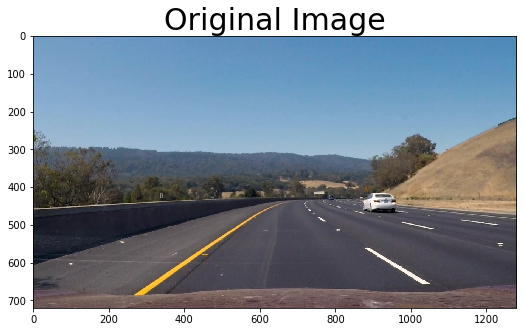

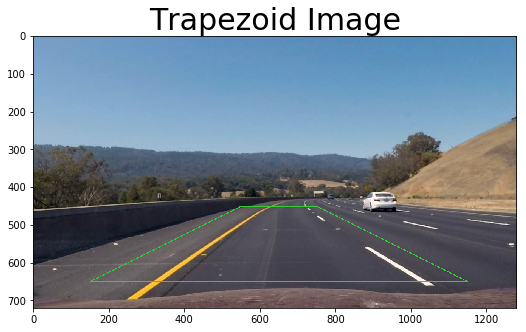

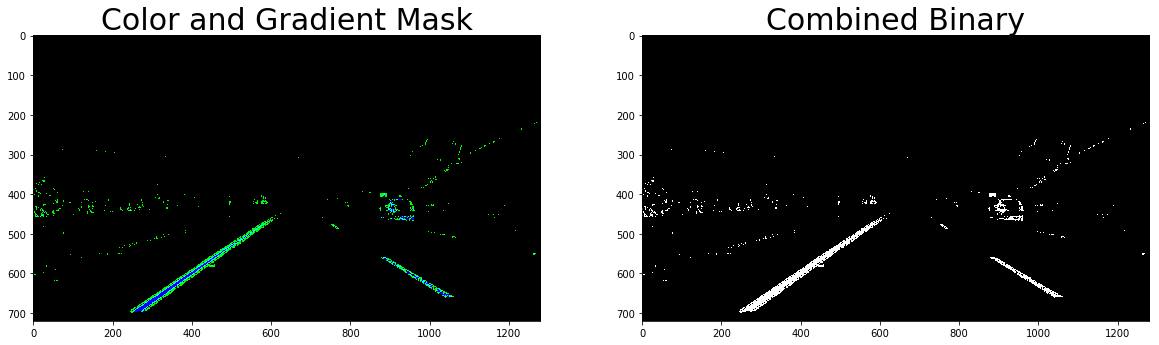

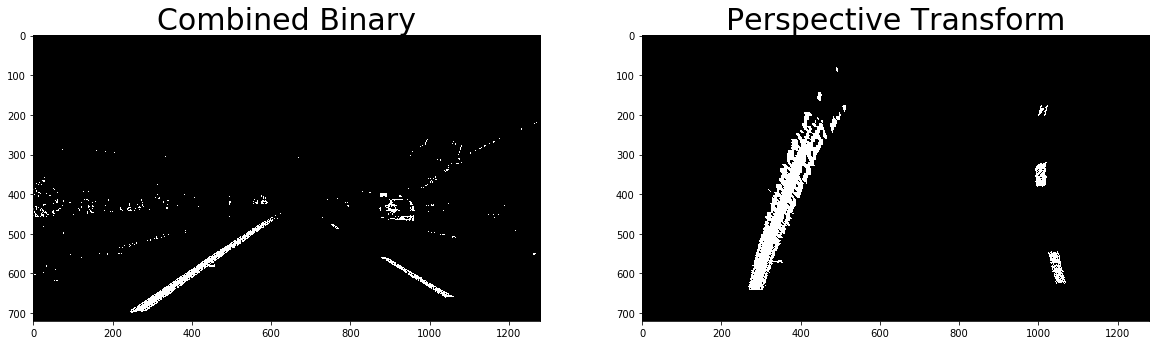

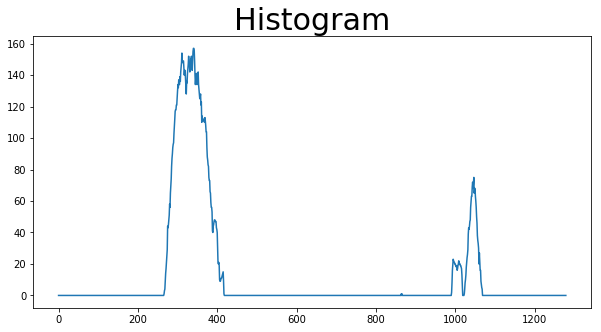

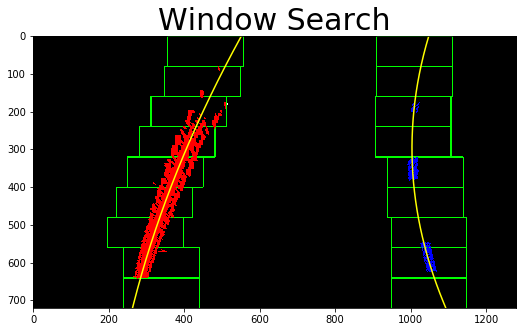

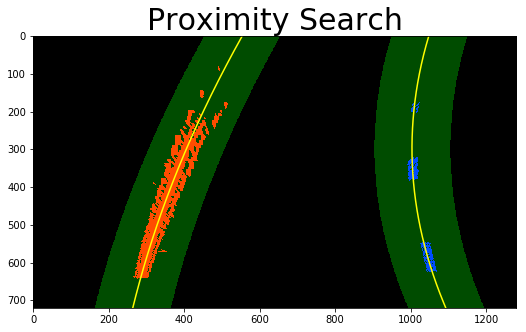

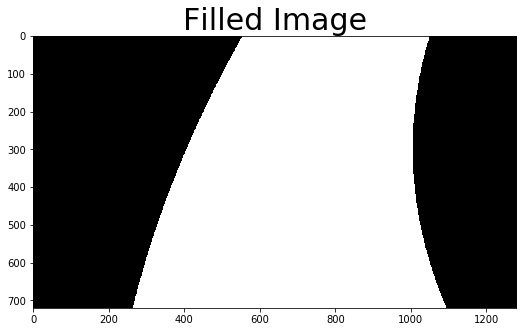

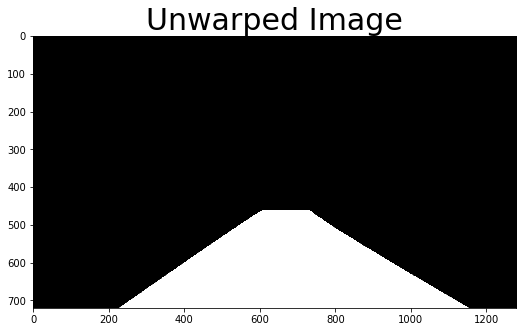

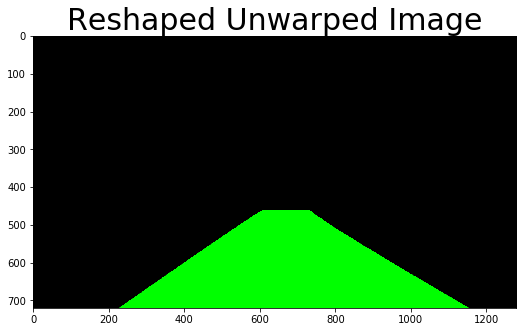

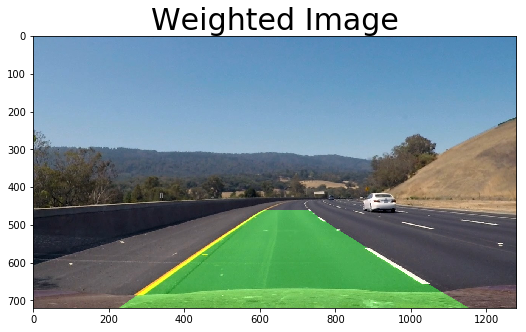

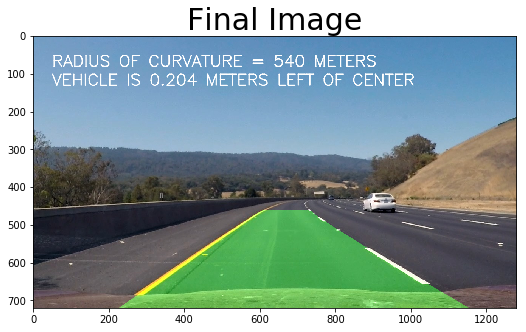

In [28]:
folder_in = 'test_images'
image_name = 'test3.jpg'
folder_out = 'output_images'

final_test_image, pipeline_images = process_test_image(folder_in, image_name, folder_out, display_results=False)

In [30]:
folder_out = 'output_images'
image_name = 'straight_lines1.jpg'

for idx, (img_name, img) in enumerate(pipeline_images.items()):
    subfolder_out = image_name.split('.')[0]
    path = "{}/{}/{}_{}".format(folder_out, subfolder_out, idx, img_name)
    
   
    if len(img.shape) >= 3:
        new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(path, new_img)
    else:
        # Make into (m,n,3)
        new_img = np.dstack((img, img, img))
        cv2.imwrite(path, new_img)
    


In [ ]:
img = pipeline_images.get('combined_binary')
print(img)

In [ ]:
img = pipeline_images['window_search.jpg']
print(img)

In [ ]:
######################################################################################################################################

# Processing Video

In [ ]:
### Process video functions
def process_image(folder_name, subfolder_name, image_name, display_results=False):

    image_path = "{}/{}/{}".format(folder_name, subfolder_name, image_name)
    original_image = read_in_image(image_path)
    undistorted_image = undistort(original_image, mtx, dist)
    src=np.array([[550, 450],[750, 450],[1150, 650],[150, 650]])
    trapezoid_image = trapezoid(undistorted_image, src)
    combined_binary, hls, s_channel, color_binary = color_and_gradient_mask(undistorted_image)
    warped_binary, M, Minv = warp_image(combined_binary, src)
    histogram = make_histogram(warped_binary)
    line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, out_img = window_search(warped_binary, histogram)
    line_fits_binary, left_fit, right_fit, avg_curverad, distance_from_center, out_img = proximity_search(warped_binary, left_fit, right_fit)   
    filled_image = fill_image(line_fits_binary)
    unwarped_image = unwarp_image(filled_image, Minv, cutoff_height=460)
    reshaped_unwarped_image = reshape_unwarped(unwarped_image)
    weighted_image = weigh_image(reshaped_unwarped_image, original_image, α=1.0, β=0.4, λ=0.)
    final_image = text_overlay(weighted_image, avg_curverad, distance_from_center)
    
    if display_results==True:
        plot_side_by_side(original_image, final_image, 'Original Image', 'Final Image')   
    
    return final_image




In [ ]:
image_name = 'test3.jpg'
folder_name = 'test_images'

final_image = process_image(folder_name, image_name, display_results=True)

In [ ]:
plt.imshow(final_image)

In [ ]:
folder_name = 'output_images'
subfolder_name = 'straight_lines1'
image_name = 'final_image.jpg'
print(folder_name)
print(image_name)
image = np.copy(final_image)
print(image.shape)
plt.imshow(image)

In [ ]:
save_image(folder_name, subfolder_name, image_name, image)

In [ ]:
gray_test = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [ ]:
save_image(folder_name, subfolder_name, image_name, gray_test)

In [ ]:
def process_images(image_names, display_results=False):
    for image_name in image_names:
        final_image = process_image(image_name)